In [1]:
!pip install -q MERF shap

     |████████████████████████████████| 575 kB 4.2 MB/s 


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from math import sqrt

from merf import MERF
import shap

from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
RETRAIN_MODEL = False

Prep Data

In [4]:
path = '/content/drive/My Drive/Colab Notebooks/job_satisfaction_project'

In [5]:
data = pd.read_csv(f"{path}/full_prepped_data.csv")

In [6]:
# only full time positions
data = data.loc[data['hours_worked_week'] >= 35]

# convert to binary
data['male'] = np.where(data['gender'] == 'male', 1, 0)
data.drop(columns='male', inplace=True)

data['urban'] = np.where(data['urban_rural'] == 'urban', 1, 0)
data.drop(columns='urban_rural', inplace=True)

data['union'] = np.where(data['union'] == 'union', 1, 0)

# drop unused features
data.drop(columns=['industry', 'full_time', 'hours_worked_week', 'hours_worked_week_centered'], inplace=True)

In [7]:
# create interaction features
data.loc[:, 'pay_age'] = data['hourly_pay_centered'] * data['avg_age_per_job_centered']
data.loc[:, 'pay_tenure'] = data['hourly_pay_centered'] * data['tenure_centered']

In [8]:
features = [c for c in data.columns if c not in ['id', 'job_satisfaction', 'year']]  # TODO unsure about year

In [9]:
def prep_data(data, features):
  clusters = data['id']
  X = pd.get_dummies(data[features])
  Z = np.ones((len(X), 1))
  y = data['job_satisfaction'].values
  return X, Z, clusters, y

In [10]:
X_train, Z_train, clusters_train, y_train = prep_data(data, features)

MERF

In [11]:
if RETRAIN_MODEL:
  # train
  mrf = MERF(max_iterations=5)  # could increase this, just using the original value
  mrf.fit(X_train, Z_train, clusters_train, y_train)
  # save
  pickle.dump(mrf, open(f'{path}/merf.sav', 'wb'))
else:
  # load pre-trained model
  mrf = pickle.load(open(f'{path}/merf.sav', 'rb'))

In [12]:
# evaluate on the train set
y_pred = mrf.predict(X_train, Z_train, clusters_train)
print("RMSE:", sqrt(mean_squared_error(y_train, y_pred)))
print("R-squared:", r2_score(y_train, y_pred))

RMSE: 0.2360912122031665
R-squared: 0.9009110038826766


SHAP

In [13]:
mrf = pickle.load(open(f'{path}/merf.sav', 'rb'))

In [12]:
expl = shap.TreeExplainer(mrf.trained_fe_model, feature_perturbation='tree_path_dependent')  # for multicollinearity

In [13]:
X_train_sample = X_train.sample(5000)  # sampling for computational speed

In [14]:
shap_values = expl.shap_values(X_train_sample, check_additivity=False)
np.save(f'{path}/shap_values.npy', shap_values)

In [15]:
X_train_sample.to_csv(f'{path}/X_train_sample.csv', index=False)

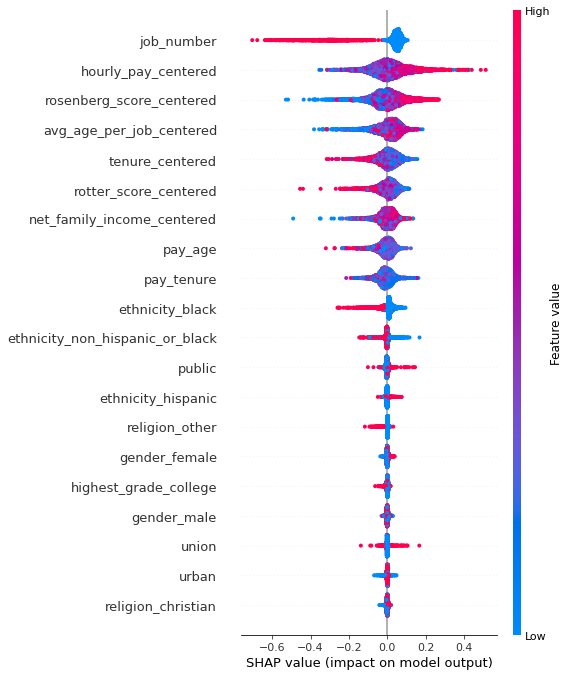

In [16]:
shap.summary_plot(shap_values, X_train_sample)

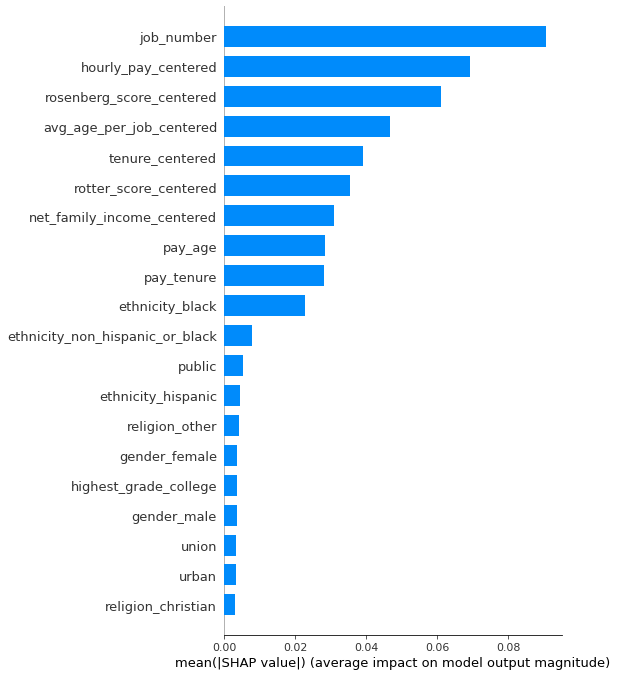

In [17]:
# feature importance
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")

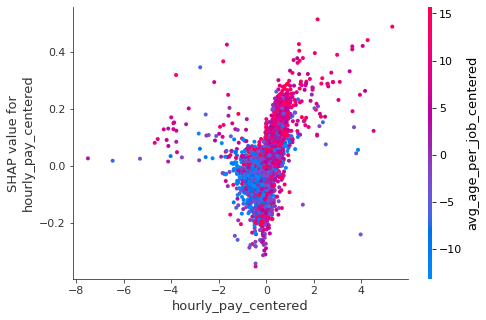

In [18]:
shap.dependence_plot("hourly_pay_centered", shap_values, X_train_sample, interaction_index="avg_age_per_job_centered")

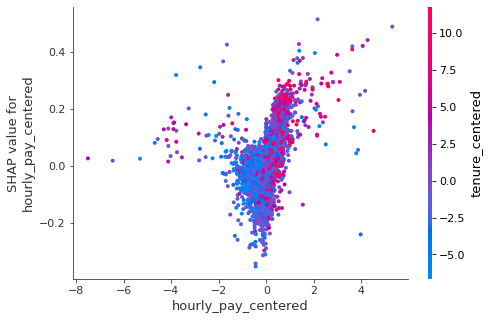

In [19]:
shap.dependence_plot("hourly_pay_centered", shap_values, X_train_sample, interaction_index="tenure_centered")

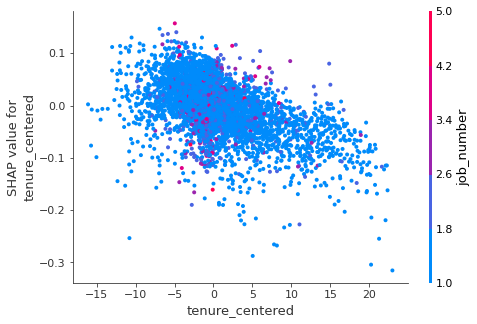

In [20]:
shap.dependence_plot("tenure_centered", shap_values, X_train_sample)

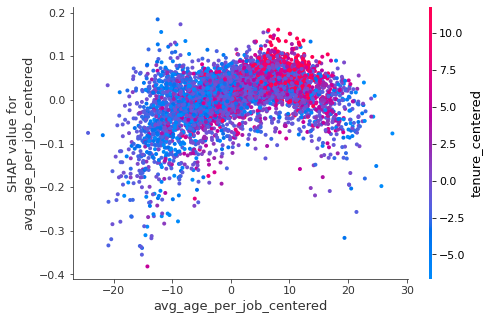

In [21]:
shap.dependence_plot("avg_age_per_job_centered", shap_values, X_train_sample)

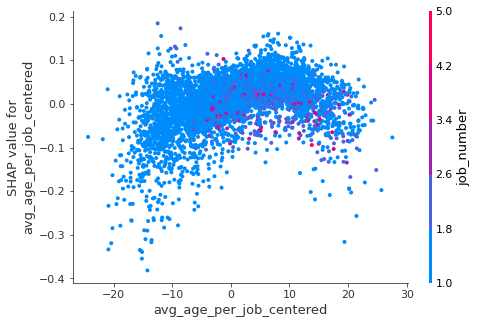

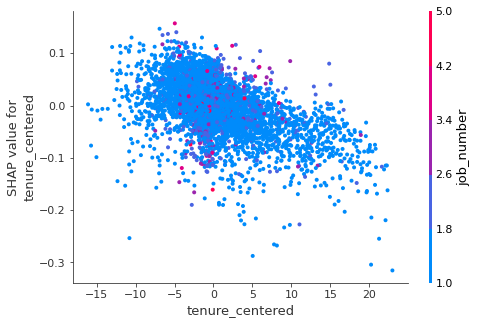

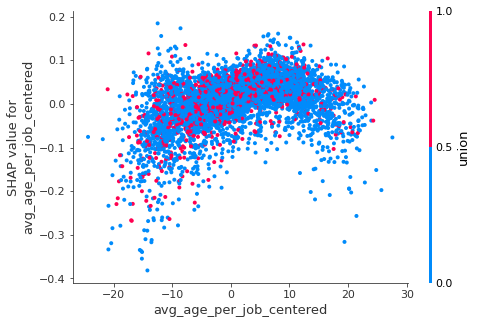

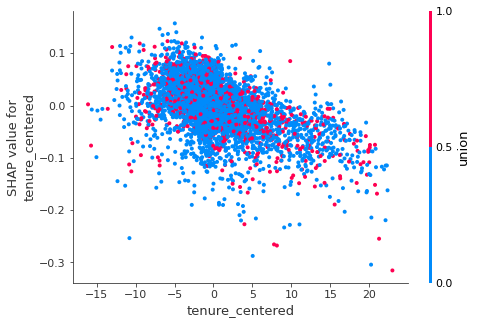

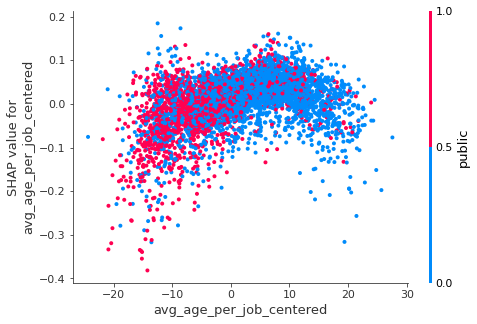

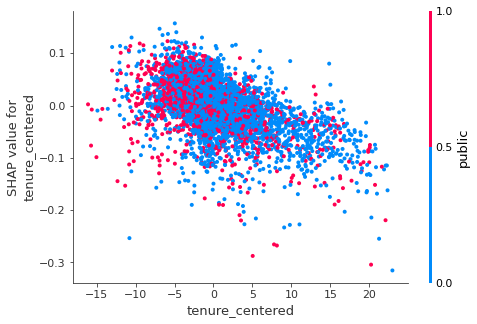

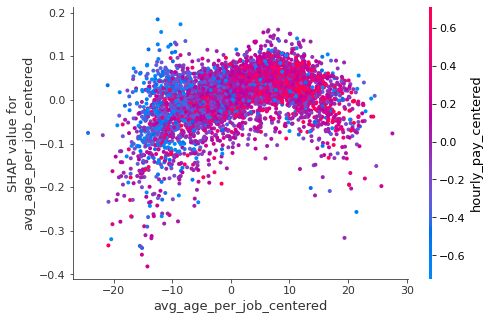

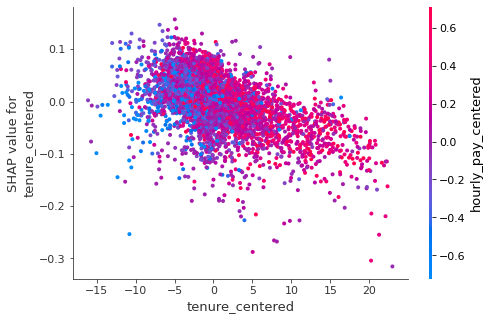

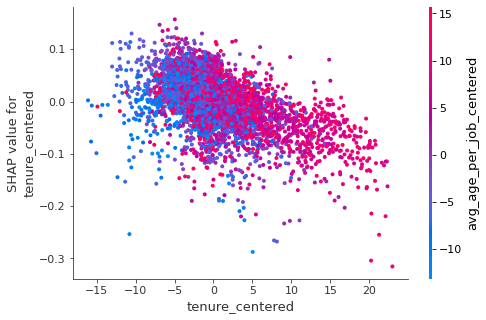

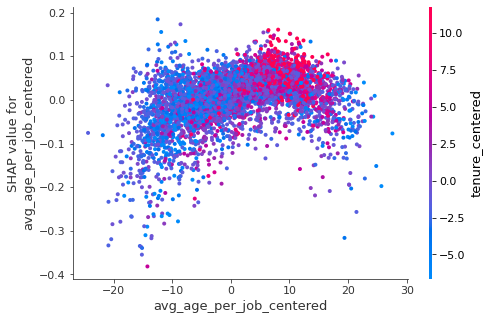

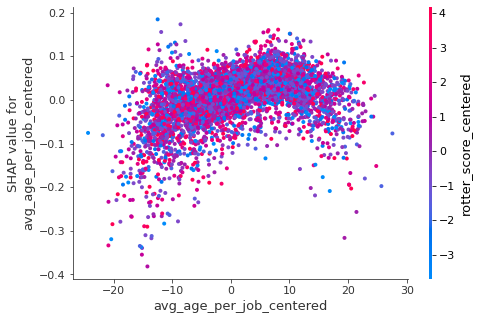

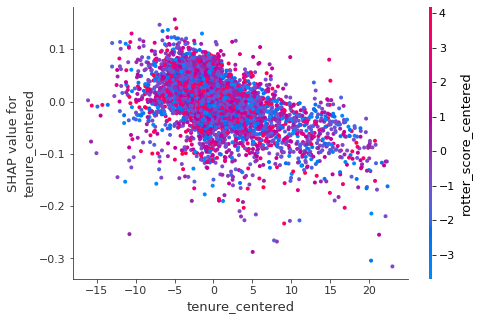

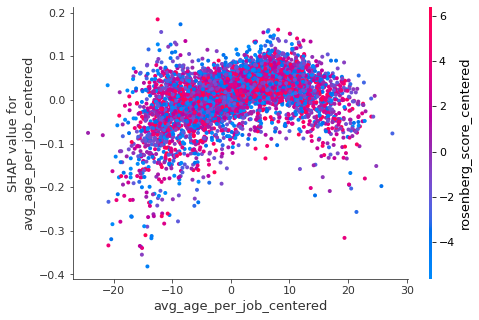

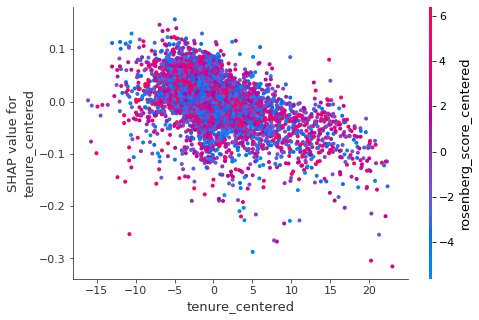

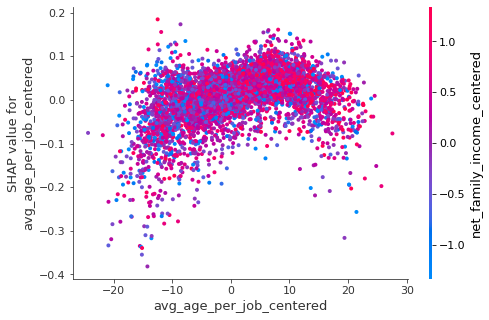

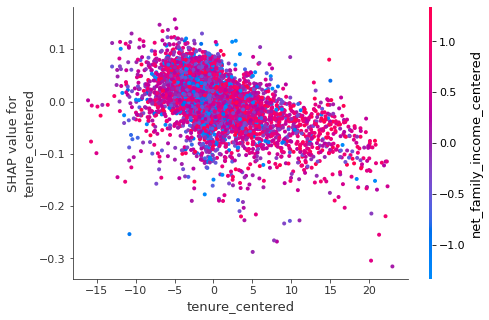

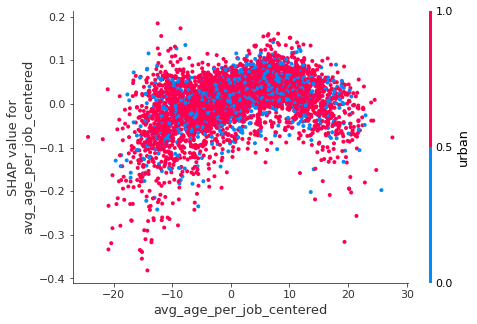

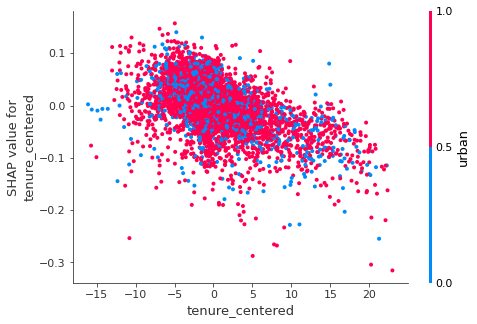

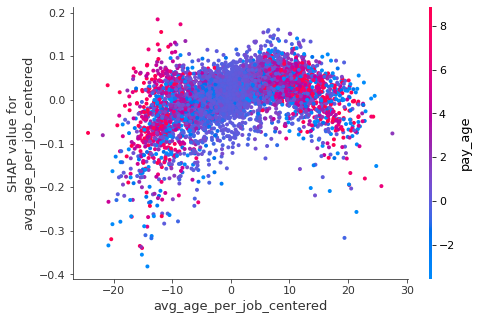

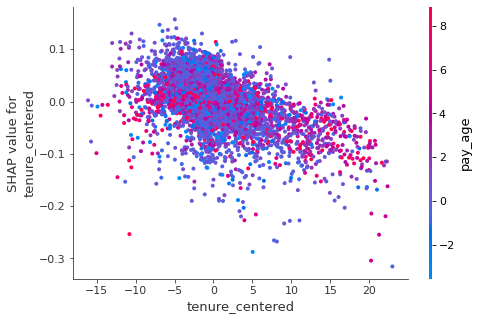

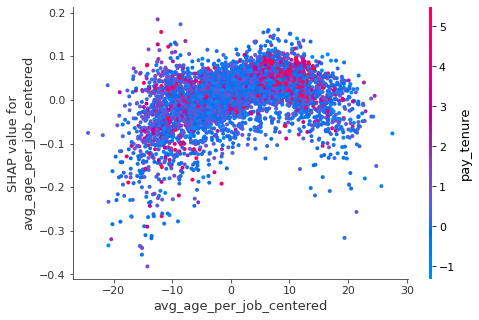

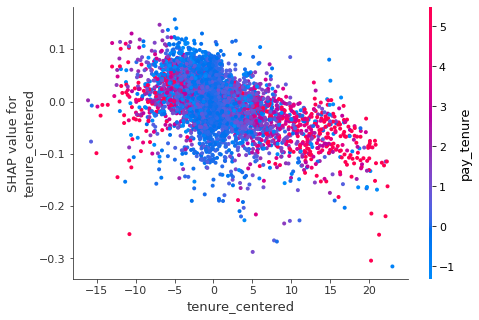

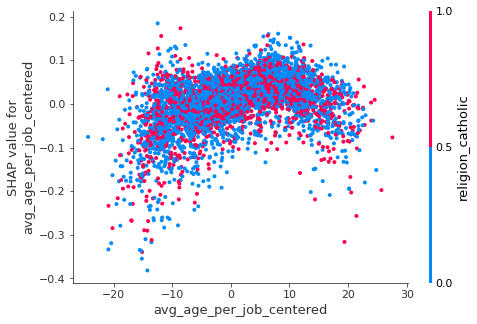

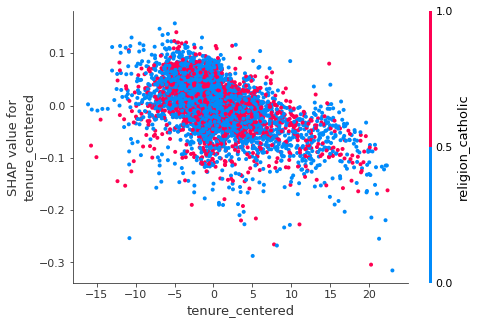

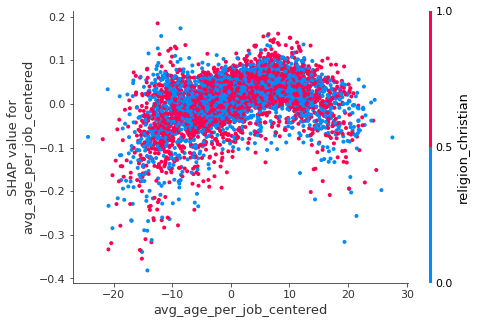

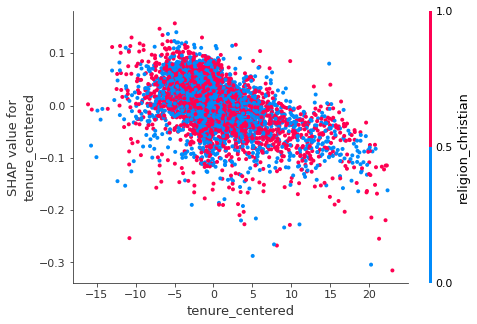

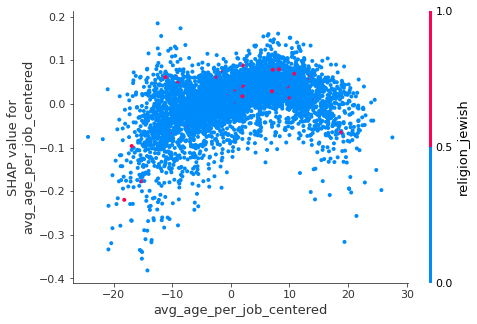

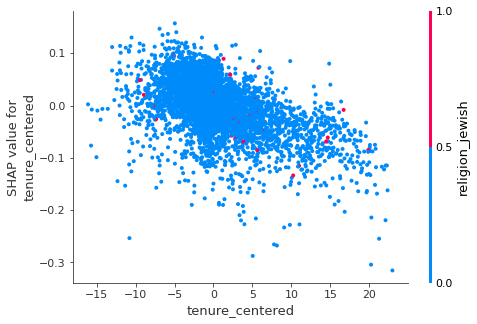

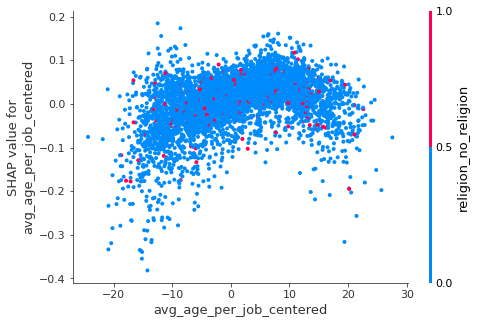

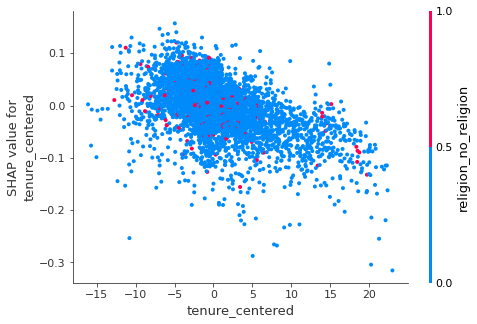

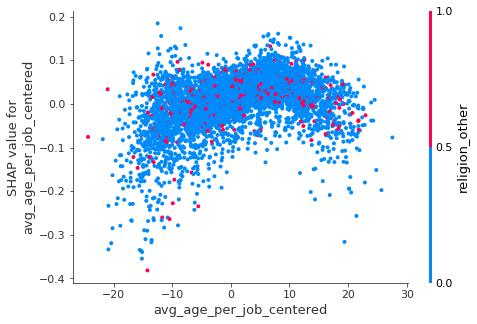

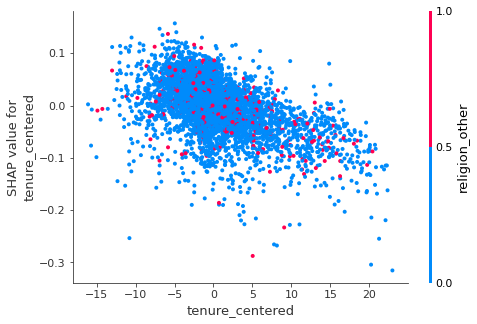

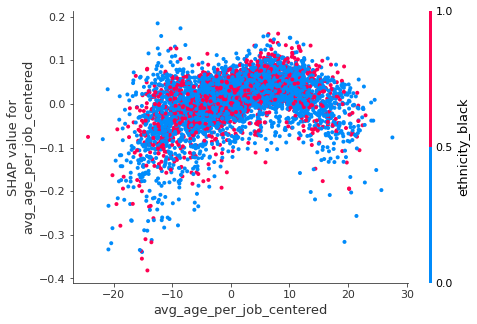

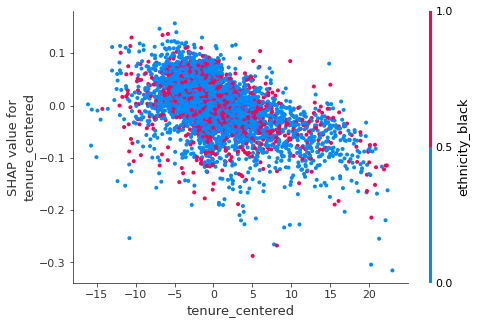

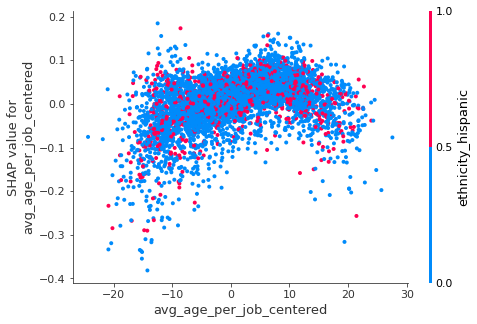

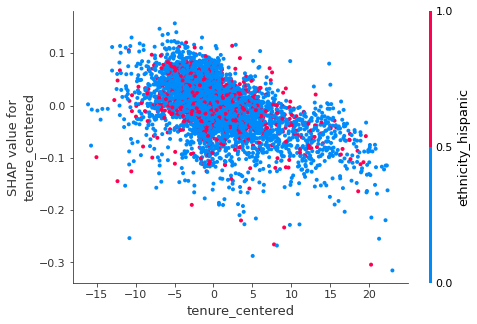

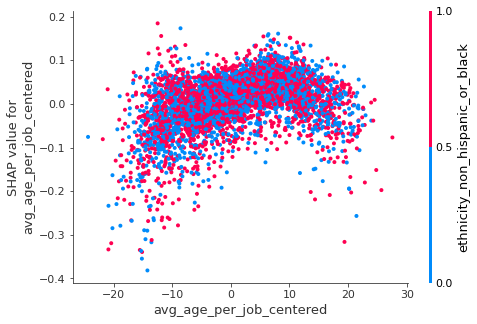

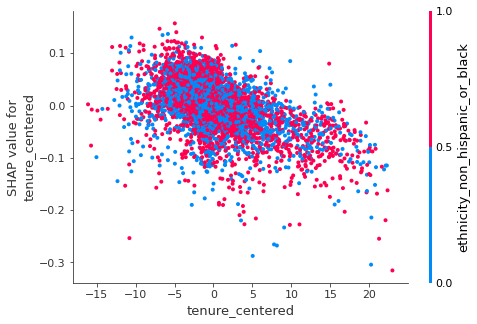

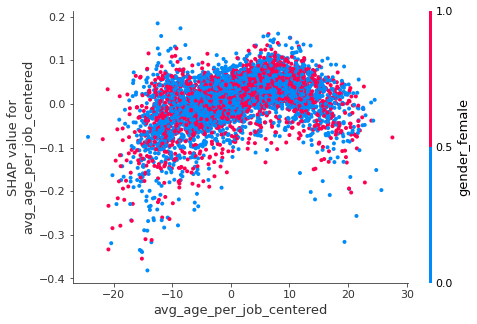

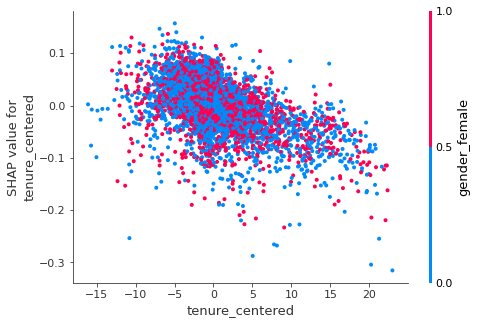

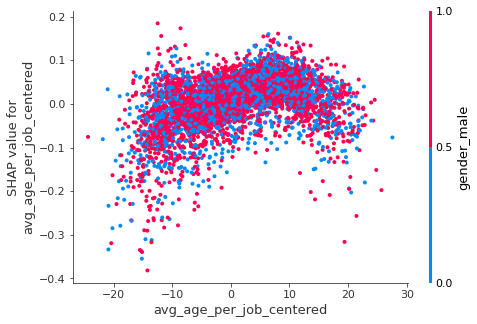

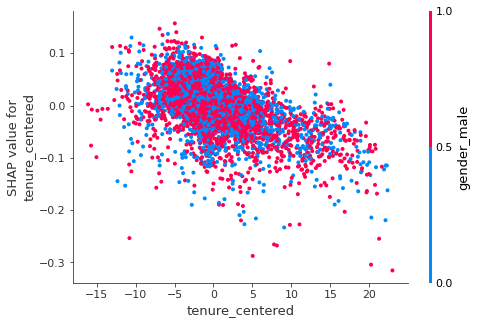

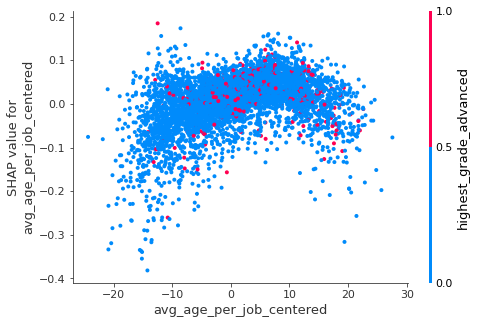

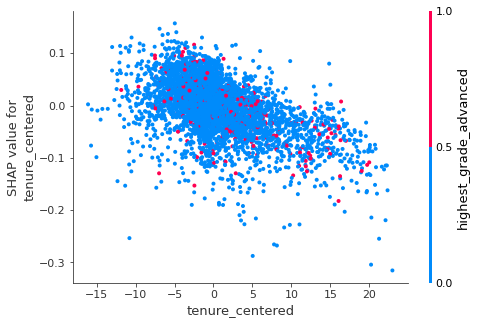

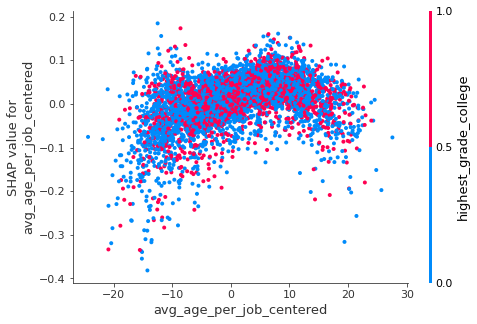

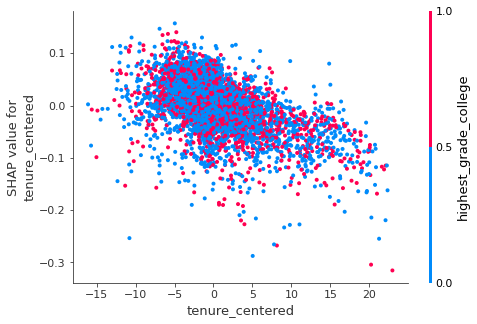

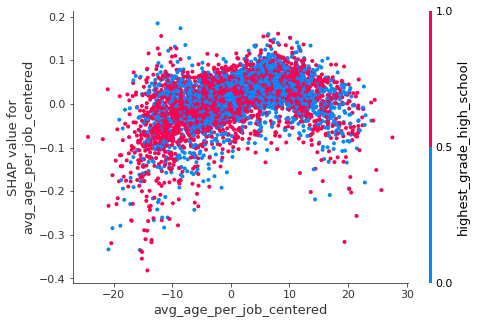

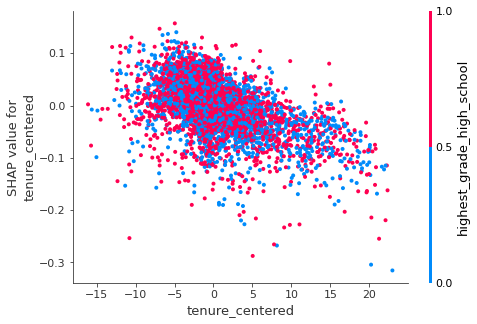

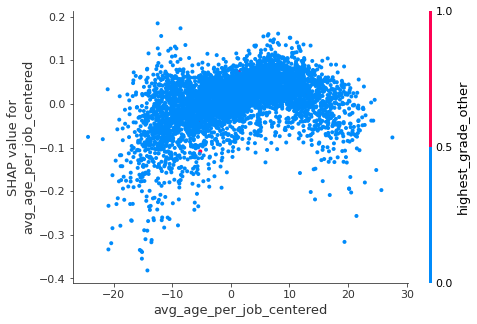

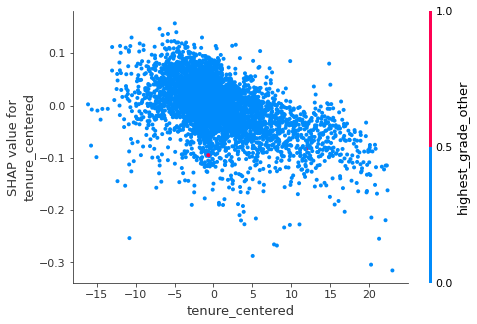

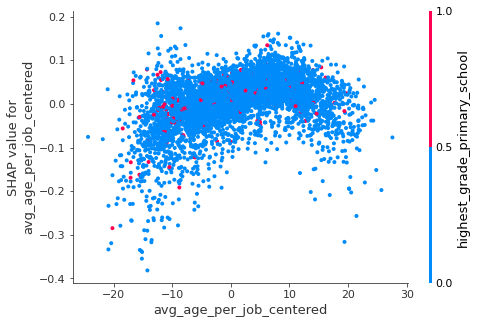

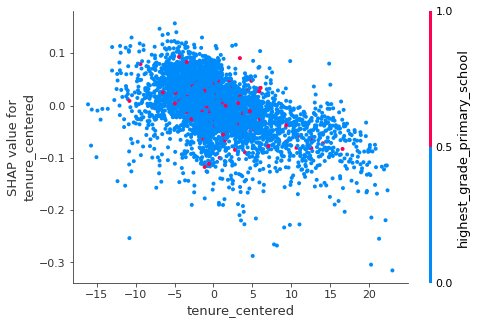

In [22]:
for f in X_train.columns:
  for v in ['avg_age_per_job_centered', 'tenure_centered']:
    if f != v:
      shap.dependence_plot(v, shap_values, X_train_sample, interaction_index=f)

In [23]:
random_respondents = X_train_sample.reset_index().sample(10)

In [24]:
shap.initjs()

# explainer.expected_value = mean job satisfaction
# shap_values for each feature of each row of the data

for i in random_respondents.index.to_list():
    display(shap.force_plot(expl.expected_value, shap_values[i], X_train_sample[i:i+1]))